In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# GMM clustering libraries
import sys
sys.path.insert(0, '../../libraries/')

import gmm_clustering_lib as gmm_lib
import utils_lib

# BNP libraries: these are pip installed
import BNP_modeling.cluster_quantities_lib as cluster_lib
import BNP_modeling.optimization_lib as optimization_lib
import BNP_modeling.modeling_lib as modeling_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

import time

# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

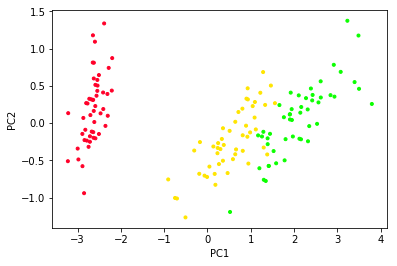

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]]), 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'alpha': 3.5}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1460.205125758913

# Optimize the KL objective

### Initialize with k-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights)

450.9718947107098

### Set up KL objective 

In [10]:
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl,
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = \
    lambda x : get_vb_params_loss(features,
                                x, prior_params_dict,
                                 gh_loc, gh_weights)


In [11]:
# # get loss as a function of vb parameters
# get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
# get_vb_params_loss.cache_args(features, None, prior_params_dict,
#                                 gh_loc, gh_weights)

# # Get loss as a function vb_free_params
# get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                         patterns=vb_params_paragami,
#                                         free=True)


In [12]:
t0 = time.time()
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

refit_time = time.time() - t0

running bfgs ... 
Iter 0: f = 450.97189471
Iter 1: f = 288.42252948
Iter 2: f = 132.82724910
Iter 3: f = 849.69522338
Iter 4: f = 102.95800124
Iter 5: f = 69.15077895
Iter 6: f = 35.10598280
Iter 7: f = 149.86270237
Iter 8: f = 27.90810015
Iter 9: f = 15.66532676
Iter 10: f = -4.96037757
Iter 11: f = -35.63242473
Iter 12: f = -69.57876702
Iter 13: f = -106.48627732
Iter 14: f = -109.56137218
Iter 15: f = -129.49640794
Iter 16: f = -148.49222218
Iter 17: f = -180.42498864
Iter 18: f = -183.90475287
Iter 19: f = -197.82029664
Iter 20: f = -223.21611941
Iter 21: f = -210.67850230
Iter 22: f = -233.90999359
Iter 23: f = -248.01428698
Iter 24: f = -266.50049101
Iter 25: f = -275.43483870
Iter 26: f = -288.85589805
Iter 27: f = -294.21119573
Iter 28: f = -301.02567169
Iter 29: f = -309.37688825
Iter 30: f = -321.41152123
Iter 31: f = -317.57546051
Iter 32: f = -326.55252540
Iter 33: f = -332.95619469
Iter 34: f = -339.92264168
Iter 35: f = -342.52883975
Iter 36: f = -346.68395276
Iter 37: f 

In [13]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

In [14]:
# plot check results
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

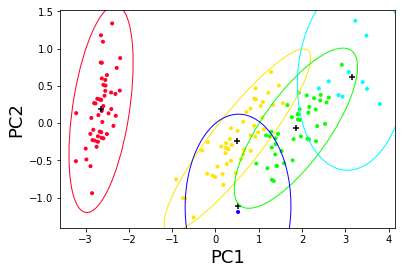

In [15]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [16]:
paragami.save_folded('./iris_fits/iris_fits_alpha{}'.format(prior_params_dict['alpha']), 
                     vb_opt_dict,
                     vb_params_paragami, 
                     alpha = prior_params_dict['alpha'], 
                    gh_deg = gh_deg, 
                    refit_time = refit_time)

# Fit for a range of alpha 

In [17]:
alpha_list = np.arange(start=0.5, stop=16, step=0.5)

print(alpha_list)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


In [18]:
def refit_with_alpha(alpha, vb_opt): 
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # set up new objective, witht the prior changed
#     get_vb_params_loss.cache_args(features, None, prior_params_pert_dict, gh_loc, gh_weights)
#     get_pert_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                             patterns=vb_params_paragami,
#                                             free=True)

    get_vb_params_loss = paragami.FlattenFunctionInput(
                                    original_fun=gmm_lib.get_kl,
                                    patterns = vb_params_paragami,
                                    free = True,
                                    argnums = 1)

    get_pert_loss = \
        lambda x : get_vb_params_loss(features,
                                    x, prior_params_pert_dict,
                                     gh_loc, gh_weights)

    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss,deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

In [19]:
for alpha in alpha_list: 
    print('######################')
    print('re-optimzing with alpha = ', alpha)
    print('######################')
    
    t0 = time.time() 
    
    vb_opt_pert = refit_with_alpha(alpha, vb_opt)
    
    vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)
    
    refit_time = time.time() - t0
    print('refit time: {:.03f}sec'.format(refit_time))
    
    filename = './iris_fits/iris_fits_alpha{}'.format(alpha)
    print('saving results to ', filename)
    paragami.save_folded(filename, 
                     vb_pert_dict,
                     vb_params_paragami, 
                     alpha = alpha, 
                    gh_deg = gh_deg, 
                    refit_time = refit_time)
    


######################
re-optimzing with alpha =  0.5
######################
running bfgs ... 
Iter 0: f = -403.98026667
Iter 1: f = -406.58768334
Iter 2: f = -373.35555425
Iter 3: f = -406.77115378
Iter 4: f = -407.08976431
Iter 5: f = -407.69260332
Iter 6: f = -408.45969136
Iter 7: f = -409.25510746
Iter 8: f = -410.21899510
Iter 9: f = -409.32334317
Iter 10: f = -410.55316632
Iter 11: f = -411.04446434
Iter 12: f = -411.83814524
Iter 13: f = -412.93145628
Iter 14: f = -413.27111412
Iter 15: f = -413.91256210
Iter 16: f = -414.80707795
Iter 17: f = -416.29114244
Iter 18: f = -418.76158287
Iter 19: f = -417.18012598
Iter 20: f = -419.76227985
Iter 21: f = -420.58341397
Iter 22: f = -422.03633425
Iter 23: f = -424.09647285
Iter 24: f = -423.41992693
Iter 25: f = -424.96106223
Iter 26: f = -425.72416428
Iter 27: f = -426.35961359
Iter 28: f = -427.36963086
Iter 29: f = -428.29806378
Iter 30: f = -428.58654454
Iter 31: f = -428.96563831
Iter 32: f = -429.40316182
Iter 33: f = -430.116020